# Import libraries

In [45]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time
import cv2
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import mediapipe as mp
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from collections import Counter

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [47]:
ROUND = 3
SEQ_LEN = 8
EXERCISE = 'half-burpee'
CUR_CLASS = 'out'
PREV_CLASS = 'in'
# SUFFIX_VID_NAME = '_hard_vote'
SUFFIX_VID_NAME = 'None'
REMOTE = True
# for benchmark model
BENCHMARK = False
BASE_CLASSES = [f'{EXERCISE}-{CUR_CLASS}',f'{EXERCISE}-{PREV_CLASS}']
if BENCHMARK:
    ROUND = 'BM'

# Initialize Mediapipe objects

In [48]:
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Load the data from disk

In [120]:
all_file_paths = []
vid_to_seqs = {}

In [121]:
if REMOTE:
    walk_path = f'/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_{SEQ_LEN}/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\keypoints_seq\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in tqdm(os.walk(walk_path)):
    # print(path, subdirs, files)
    if files:
        split = path.split(os.path.sep)
        vid_name = os.path.join(split[-2], split[-1]) # pushup-up/10_1
        sub_arr = []
        for file_name in files:
            if file_name.endswith('.npy'):
                if BENCHMARK:
                    if split[-2] in BASE_CLASSES:
                        full_path = os.path.join(path, file_name)
                        all_file_paths.append(full_path)
                        sub_arr.append(full_path)
                else:
                    full_path = os.path.join(path, file_name)
                    all_file_paths.append(full_path)
                    sub_arr.append(full_path)
        vid_to_seqs[vid_name] = sub_arr

450it [00:00, 24002.81it/s]


In [122]:
# vid_to_seqs

In [123]:
# all_file_paths

In [124]:
# use to check the balance of data and fit LabelEncoder
labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
labels

['others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',

In [125]:
# all data
Counter(labels)

Counter({'others': 2837,
         'idle': 1339,
         'half-burpee-in': 1339,
         'half-burpee-out': 2048})

In [126]:
# will be use for class weighting later
# total = len(labels)
# label_count = Counter(labels)
# label_count, total

In [127]:
def load_numpy(path):
    return np.load(path.numpy())

In [128]:
def load_data(file_path):
    # load numpy, file_path is Tensor with dtype string
    # and np.load not working with Tensor, so we need to work around with pure tf ops
    # this function return a list with elements following Tout, 
    # so we need to access first item
    data = tf.py_function(load_numpy, inp=[file_path], Tout=[tf.float32])[0] # return as tensor with dtype tf.float32

    # get label
    label_str = tf.strings.split(file_path, os.path.sep)[-3]
    one_hot = label_str == le.classes_ # get tensor with dtype bool
    label = tf.cast(one_hot, tf.int32)
    return data, label

# Preprocess Data

In [129]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['half-burpee-in', 'half-burpee-out', 'idle', 'others'],
      dtype='<U15')

In [130]:
labels = le.transform(labels)
labels

array([3, 3, 3, ..., 1, 1, 1])

### Split video-level splitting

In [16]:
# split_vids = list(vid_to_seqs.keys())
# split_vids

In [15]:
# split_vids_class = list(map(lambda x: x.split('/')[0], split_vids))

In [19]:
# split vid level balanceness
# Counter(split_vids_class)

Counter({'squat-down': 122, 'squat-up': 123, 'idle': 122, 'others': 122})

In [20]:
# check correctness
# len(split_vids), len(np.unique(split_vids))

(489, 489)

In [21]:
# train_vids, test_vids = train_test_split(split_vids, test_size=0.1, random_state=42, stratify=split_vids_class)

In [22]:
# len(train_vids), len(test_vids)

(440, 49)

In [23]:
# check stratify
# Counter(list(map(lambda x: x.split('/')[0], test_vids)))

Counter({'idle': 12, 'squat-down': 12, 'others': 12, 'squat-up': 13})

In [16]:
# map train_vids/test_vids to their corresponding paths
def vid_to_seq_level(vids_list, vid_seq_mapping):
    for i in range(len(vids_list)):
        if i == 0: # first iteration
            result = vid_seq_mapping[vids_list[i]].copy()
        else:
            result.extend(vid_seq_mapping[vids_list[i]])
    return result

In [25]:
# train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
# test_paths = vid_to_seq_level(test_vids, vid_to_seqs)

In [26]:
# train_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_20.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_18.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_36.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_35.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_52.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_33.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_17.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_25.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_12.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_37.npy',
 '/home/u6

In [27]:
# len(train_paths), len(test_paths)

(13589, 1851)

In [28]:
# # will be use for class weighting later
# labels = list(map(lambda x: x.split(os.path.sep)[-3], train_paths))
# total = len(labels)
# label_count = Counter(labels)
# label_count, total

(Counter({'squat-down': 3808, 'idle': 3803, 'others': 2760, 'squat-up': 3218}),
 13589)

### Sequence-level splitting

In [131]:
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)

In [132]:
len(train_paths), len(test_paths)

(6806, 757)

In [133]:
# will be use for class weighting later
labels = list(map(lambda x: x.split(os.path.sep)[-3], train_paths))
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'half-burpee-in': 1205,
          'half-burpee-out': 1843,
          'idle': 1205,
          'others': 2553}),
 6806)

# Training prep

In [134]:
def build_model():
    model = tf.keras.models.Sequential([
        # ลด lstm จำนวน unit 64
        tf.keras.layers.LSTM(64, return_sequences=False, activation='relu', input_shape=(SEQ_LEN, 99)),
    #     tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    #     tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [135]:
# define hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

---

# Cross-validation training

## Split-vid level

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

split_vids = np.array(split_vids)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

all_y_hat_test = []
all_y_test = []
for f_idx, (train_index, test_index) in enumerate(skf.split(split_vids, split_vids_class)):
    print(f'-= [Fold {f_idx}] =-')
    train_vids, test_vids = split_vids[train_index], split_vids[test_index]
    
    train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
    test_paths = vid_to_seq_level(test_vids, vid_to_seqs)
    
    total = len(train_paths)
    label_count = Counter(list(map(lambda x: x.split(os.path.sep)[-3], train_paths)))
    
    print(f'Train vid amount: {len(train_vids)} | Test vid amount: {len(test_vids)}')
    print(f'Train seq amount: {len(train_paths)} | Test seq amount: {len(test_paths)}')
    print(f'Train seq label count: {dict(sorted(label_count.items()))}')
    print(f'Test seq label count: {dict(sorted(Counter(list(map(lambda x: x.split(os.path.sep)[-3], test_paths))).items()))}')
    
    # class weighting
    NUM_CLASSES = len(le.classes_)
    class_weights = {}
    for label in label_count:
        class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)
    print('Classes:', le.classes_)
    print('Class weights:', dict(sorted(class_weights.items())))
        
    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    train_ds = (train_ds
                .shuffle(len(train_paths), seed=42)
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
    test_ds = (test_ds
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    model = build_model()
    log_dir = os.path.join('Logs')
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    hist = model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)
    
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=1)
    raw_y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = np.argmax(raw_y_test, axis=1)
    
    print(f'Test Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'Test Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')
    
    # run per class for each metrics
    fold['train_loss'].append(hist.history['loss'][-15])
    fold['val_loss'].append(hist.history['val_loss'][-15])
    fold['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_hat_test))
    fold['precision'].append(precision_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['recall'].append(recall_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['f1'].append(f1_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    
    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)
    
all_y_hat_test = np.vstack(all_y_hat_test)
all_y_test = np.vstack(all_y_test)

NameError: name 'split_vids' is not defined

In [68]:
save_cv = f'/data1-6tb/jom/EzFit_models/saved_artifacts/cv_result/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cv):
    os.makedirs(save_cv, exist_ok=True)
with open(os.path.join(save_cv,f'{EXERCISE}_kps_seq_cv.pickle'), 'wb') as file:
    pickle.dump(fold, file)

In [69]:
# avg cv
fold

{'train_loss': [0.5755961537361145,
  0.2991354465484619,
  0.38023537397384644,
  0.3500932455062866,
  0.3323803246021271,
  0.25822094082832336,
  0.22903253138065338,
  0.417510449886322,
  0.1977362334728241,
  0.408559113740921],
 'val_loss': [0.9740620255470276,
  0.4259565472602844,
  0.468708872795105,
  0.6667155027389526,
  1.0760188102722168,
  1.2720816135406494,
  1.4981669187545776,
  0.5732372999191284,
  0.4483863413333893,
  1.3011795282363892],
 'accuracy': [0.5752753977968176,
  0.9009009009009009,
  0.8355795148247979,
  0.7520325203252033,
  0.8719851576994434,
  0.712707182320442,
  0.6927860696517413,
  0.8461538461538461,
  0.9180035650623886,
  0.6611675126903553],
 'precision': [0.5718178047209207,
  0.882798680463461,
  0.7993517953643201,
  0.6892821295255289,
  0.8509920634920636,
  0.7419217522728678,
  0.6162091982208939,
  0.7933465795859209,
  0.9027062145976154,
  0.6845026115859449],
 'recall': [0.5376605359826435,
  0.8756083075787628,
  0.803973169

## Sequence level

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
all_file_paths = np.array(all_file_paths)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

all_y_hat_test = []
all_y_test = []
for f_idx, (train_index, test_index) in enumerate(skf.split(all_file_paths, labels)):
    print(f'-= [Fold {f_idx}] =-')
    train_paths, test_paths = all_file_paths[train_index], all_file_paths[test_index]
    
    # train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
    # test_paths = vid_to_seq_level(test_vids, vid_to_seqs)
    
    total = len(train_paths)
    label_count = Counter(list(map(lambda x: x.split(os.path.sep)[-3], train_paths)))
    
    # print(f'Train vid amount: {len(train_vids)} | Test vid amount: {len(test_vids)}')
    print(f'Train seq amount: {len(train_paths)} | Test seq amount: {len(test_paths)}')
    print(f'Train seq label count: {dict(sorted(label_count.items()))}')
    print(f'Test seq label count: {dict(sorted(Counter(list(map(lambda x: x.split(os.path.sep)[-3], test_paths))).items()))}')
    
    # class weighting
    NUM_CLASSES = len(le.classes_)
    class_weights = {}
    for label in label_count:
        class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)
    print('Classes:', le.classes_)
    print('Class weights:', dict(sorted(class_weights.items())))
        
    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    train_ds = (train_ds
                .shuffle(len(train_paths), seed=42)
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
    test_ds = (test_ds
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    model = build_model()
    log_dir = os.path.join('Logs')
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    hist = model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)
    
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=1)
    raw_y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = np.argmax(raw_y_test, axis=1)
    
    print(f'Test Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'Test Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')
    
    # run per class for each metrics
    fold['train_loss'].append(hist.history['loss'][-15])
    fold['val_loss'].append(hist.history['val_loss'][-15])
    fold['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_hat_test))
    fold['precision'].append(precision_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['recall'].append(recall_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['f1'].append(f1_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    
    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)
    
all_y_hat_test = np.vstack(all_y_hat_test)
all_y_test = np.vstack(all_y_test)

-= [Fold 0] =-
Train seq amount: 13896 | Test seq amount: 1544
Train seq label count: {'idle': 3862, 'others': 2898, 'squat-down': 3862, 'squat-up': 3274}
Test seq label count: {'idle': 429, 'others': 323, 'squat-down': 429, 'squat-up': 363}
Classes: ['idle' 'others' 'squat-down' 'squat-up']
Class weights: {0: 0.8995339202485758, 1: 1.1987577639751552, 2: 0.8995339202485758, 3: 1.0610873549175321}


2022-06-06 15:56:17.289614: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-06 15:56:17.349730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 15:56:17.350260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-06-06 15:56:17.350276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-06 15:56:17.351620: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-06 15:56:17.351645: I tensorflow/stream_executor/plat

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2022-06-06 15:56:18.213856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-06 15:56:18.215041: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3500105000 Hz
2022-06-06 15:56:18.930170: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  1/435 [..............................] - ETA: 7:21 - loss: 1.4367 - accuracy: 0.3438

2022-06-06 15:56:19.259541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-06-06 15:56:19.355814: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 15:56:19.355837: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 1:35 - loss: 1.4190 - accuracy: 0.2708

2022-06-06 15:56:19.553040: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 15:56:19.559012: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 15:56:19.590977: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 15:56:19.606793: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 15:56:19.636629: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_15_56_19
2022-06-06 15:56:19.661441: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_06_15_56_19/jarvis.trace.json.gz
2022-06-06 15:56:19.690666: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 12s 25ms/step - loss: 0.8518 - accuracy: 0.5907 - val_loss: 0.8142 - val_accuracy: 0.6354
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.6966 - accuracy: 0.6997 - val_loss: 0.6315 - val_accuracy: 0.7416
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5645 - accuracy: 0.7648 - val_loss: 0.5004 - val_accuracy: 0.8193
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4949 - accuracy: 0.7991 - val_loss: 0.4624 - val_accuracy: 0.8303
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4494 - accuracy: 0.8209 - val_loss: 0.3835 - val_accuracy: 0.8582
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4184 - accuracy: 0.8351 - val_loss: 0.3877 - val_accuracy: 0.8536
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3793 - accuracy: 0.8493 - val_loss: 0.3353 - val_accuracy: 0.8802
Epo

2022-06-06 16:02:44.847396: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:02:44.847419: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:02:44.932059: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:02:44.932170: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:58 - loss: 1.5100 - accuracy: 0.2656

2022-06-06 16:02:45.798994: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:02:45.799010: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 2:06 - loss: 1.4868 - accuracy: 0.2500

2022-06-06 16:02:46.108123: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 16:02:46.116754: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 16:02:46.149348: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 16:02:46.167691: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:02:46.202715: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_16_02_46
2022-06-06 16:02:46.229233: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_06_16_02_46/jarvis.trace.json.gz
2022-06-06 16:02:46.261260: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 12s 26ms/step - loss: 0.8676 - accuracy: 0.5781 - val_loss: 0.7771 - val_accuracy: 0.6334
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.6395 - accuracy: 0.7351 - val_loss: 0.6064 - val_accuracy: 0.7500
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5121 - accuracy: 0.7963 - val_loss: 0.4468 - val_accuracy: 0.8381
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4525 - accuracy: 0.8242 - val_loss: 0.4161 - val_accuracy: 0.8484
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4145 - accuracy: 0.8426 - val_loss: 0.3829 - val_accuracy: 0.8646
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3786 - accuracy: 0.8569 - val_loss: 0.3649 - val_accuracy: 0.8698
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3713 - accuracy: 0.8582 - val_loss: 0.3926 - val_accuracy: 0.8517
Epo

2022-06-06 16:09:13.200622: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:09:13.200642: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:09:13.284876: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:09:13.285003: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:32 - loss: 1.4192 - accuracy: 0.1406

2022-06-06 16:09:14.135155: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:09:14.135186: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 1:54 - loss: 1.4178 - accuracy: 0.2708

2022-06-06 16:09:14.429121: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 16:09:14.434653: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 16:09:14.464159: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 16:09:14.482675: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:09:14.517427: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_16_09_14
2022-06-06 16:09:14.543393: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_06_16_09_14/jarvis.trace.json.gz
2022-06-06 16:09:14.578087: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 12s 27ms/step - loss: 0.8464 - accuracy: 0.5804 - val_loss: 0.8712 - val_accuracy: 0.5719
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.7487 - accuracy: 0.6410 - val_loss: 0.7504 - val_accuracy: 0.6580
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5463 - accuracy: 0.7735 - val_loss: 0.4783 - val_accuracy: 0.8264
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4598 - accuracy: 0.8116 - val_loss: 0.4208 - val_accuracy: 0.8543
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4159 - accuracy: 0.8395 - val_loss: 0.3725 - val_accuracy: 0.8491
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3924 - accuracy: 0.8479 - val_loss: 0.3381 - val_accuracy: 0.8737
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3750 - accuracy: 0.8542 - val_loss: 0.3423 - val_accuracy: 0.8737
Epo

2022-06-06 16:18:14.739665: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:18:14.739685: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:18:14.827801: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:18:14.827915: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:19 - loss: 1.4196 - accuracy: 0.2188

2022-06-06 16:18:15.698676: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:18:15.698695: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 1:51 - loss: 1.4409 - accuracy: 0.2188

2022-06-06 16:18:15.975380: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 16:18:15.976028: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 16:18:16.007014: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 16:18:16.027276: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:18:16.061617: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_16_18_16
2022-06-06 16:18:16.090358: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_06_16_18_16/jarvis.trace.json.gz
2022-06-06 16:18:16.124373: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 12s 26ms/step - loss: 0.8612 - accuracy: 0.5800 - val_loss: 0.7781 - val_accuracy: 0.6574
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.6478 - accuracy: 0.7196 - val_loss: 0.5778 - val_accuracy: 0.7830
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4876 - accuracy: 0.8077 - val_loss: 0.4730 - val_accuracy: 0.8122
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4424 - accuracy: 0.8247 - val_loss: 0.4327 - val_accuracy: 0.8303
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3947 - accuracy: 0.8470 - val_loss: 0.4423 - val_accuracy: 0.8310
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3839 - accuracy: 0.8503 - val_loss: 0.3739 - val_accuracy: 0.8692
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3543 - accuracy: 0.8638 - val_loss: 0.3592 - val_accuracy: 0.8711
Epo

2022-06-06 16:25:54.065831: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:25:54.065855: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:25:54.151265: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:25:54.151396: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 2:39 - loss: 1.3905 - accuracy: 0.3281

2022-06-06 16:25:55.139027: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:25:55.139044: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:25:55.476136: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 16:25:55.476710: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 16:25:55.524167: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 16:25:55.546829: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:25:55.591876: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_16_25_55
2022-06-06 16:25:55.615757: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped too

435/435 [==============================] - 12s 27ms/step - loss: 0.8506 - accuracy: 0.5975 - val_loss: 0.7744 - val_accuracy: 0.6839
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.6477 - accuracy: 0.7273 - val_loss: 0.6559 - val_accuracy: 0.7383
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5112 - accuracy: 0.7984 - val_loss: 0.4943 - val_accuracy: 0.8238
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4481 - accuracy: 0.8274 - val_loss: 0.4138 - val_accuracy: 0.8504
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4139 - accuracy: 0.8371 - val_loss: 0.4141 - val_accuracy: 0.8465
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3895 - accuracy: 0.8476 - val_loss: 0.3468 - val_accuracy: 0.8821
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3693 - accuracy: 0.8590 - val_loss: 0.3260 - val_accuracy: 0.8886
Epo

2022-06-06 16:36:41.909221: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:36:41.909245: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:36:41.995965: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:36:41.996093: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:24 - loss: 1.3778 - accuracy: 0.2500

2022-06-06 16:36:42.869493: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:36:42.869515: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 1:51 - loss: 1.3795 - accuracy: 0.2812

2022-06-06 16:36:43.143875: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 16:36:43.145831: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 16:36:43.175477: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 16:36:43.195941: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:36:43.234088: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_16_36_43
2022-06-06 16:36:43.259247: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_06_16_36_43/jarvis.trace.json.gz
2022-06-06 16:36:43.298024: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 12s 26ms/step - loss: 0.8386 - accuracy: 0.5981 - val_loss: 0.7838 - val_accuracy: 0.6677
Epoch 2/150
435/435 [==============================] - 4s 9ms/step - loss: 0.6432 - accuracy: 0.7234 - val_loss: 0.5045 - val_accuracy: 0.8128
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5029 - accuracy: 0.7976 - val_loss: 0.4520 - val_accuracy: 0.8374
Epoch 4/150
435/435 [==============================] - 4s 9ms/step - loss: 0.4523 - accuracy: 0.8214 - val_loss: 0.4114 - val_accuracy: 0.8491
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4169 - accuracy: 0.8369 - val_loss: 0.3764 - val_accuracy: 0.8562
Epoch 6/150
435/435 [==============================] - 4s 9ms/step - loss: 0.3950 - accuracy: 0.8483 - val_loss: 0.3586 - val_accuracy: 0.8750
Epoch 7/150
435/435 [==============================] - 4s 9ms/step - loss: 0.3709 - accuracy: 0.8590 - val_loss: 0.3306 - val_accuracy: 0.8834
Epoch 8

2022-06-06 16:46:19.915289: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:46:19.915311: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:46:20.001423: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:46:20.001560: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:47 - loss: 1.4354 - accuracy: 0.2656

2022-06-06 16:46:21.151923: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:46:21.151943: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:46:21.447290: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 16:46:21.451295: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 16:46:21.493113: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 16:46:21.515950: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:46:21.558586: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_16_46_21
2022-06-06 16:46:21.583984: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped too

435/435 [==============================] - 12s 26ms/step - loss: 0.8784 - accuracy: 0.5640 - val_loss: 0.7762 - val_accuracy: 0.6652
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.6773 - accuracy: 0.7051 - val_loss: 0.5491 - val_accuracy: 0.7824
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5589 - accuracy: 0.7701 - val_loss: 0.4806 - val_accuracy: 0.8193
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4731 - accuracy: 0.8079 - val_loss: 0.4045 - val_accuracy: 0.8497
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4475 - accuracy: 0.8230 - val_loss: 0.3840 - val_accuracy: 0.8640
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4100 - accuracy: 0.8364 - val_loss: 0.4013 - val_accuracy: 0.8517
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3958 - accuracy: 0.8446 - val_loss: 0.3630 - val_accuracy: 0.8711
Epo

2022-06-06 16:54:32.154698: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:54:32.154718: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:54:32.242367: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:54:32.242497: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:29 - loss: 1.5431 - accuracy: 0.1406

2022-06-06 16:54:33.128360: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 16:54:33.128376: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 16:54:33.414071: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 16:54:33.424776: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 16:54:33.458609: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 16:54:33.479249: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 16:54:33.515797: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_16_54_33
2022-06-06 16:54:33.541553: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped too

435/435 [==============================] - 12s 26ms/step - loss: 0.8515 - accuracy: 0.5766 - val_loss: 0.8192 - val_accuracy: 0.6095
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.7479 - accuracy: 0.6527 - val_loss: 0.7237 - val_accuracy: 0.6904
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5698 - accuracy: 0.7563 - val_loss: 0.4981 - val_accuracy: 0.7960
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4501 - accuracy: 0.8196 - val_loss: 0.4864 - val_accuracy: 0.8063
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3953 - accuracy: 0.8454 - val_loss: 0.3796 - val_accuracy: 0.8705
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3760 - accuracy: 0.8566 - val_loss: 0.3980 - val_accuracy: 0.8374
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3560 - accuracy: 0.8630 - val_loss: 0.3547 - val_accuracy: 0.8750
Epo

2022-06-06 17:02:29.413623: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 17:02:29.413641: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 17:02:29.499622: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 17:02:29.499756: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:47 - loss: 1.3768 - accuracy: 0.3594

2022-06-06 17:02:30.670317: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 17:02:30.670335: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 17:02:30.967188: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 17:02:30.976565: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 17:02:31.020852: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 17:02:31.043136: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 17:02:31.087265: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_17_02_31
2022-06-06 17:02:31.110737: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped too

  7/435 [..............................] - ETA: 52s - loss: 1.3522 - accuracy: 0.3348 

2022-06-06 17:02:31.170788: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to Logs/train/plugins/profile/2022_06_06_17_02_31/jarvis.memory_profile.json.gz
2022-06-06 17:02:31.171651: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: Logs/train/plugins/profile/2022_06_06_17_02_31Dumped tool data for xplane.pb to Logs/train/plugins/profile/2022_06_06_17_02_31/jarvis.xplane.pb
Dumped tool data for overview_page.pb to Logs/train/plugins/profile/2022_06_06_17_02_31/jarvis.overview_page.pb
Dumped tool data for input_pipeline.pb to Logs/train/plugins/profile/2022_06_06_17_02_31/jarvis.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to Logs/train/plugins/profile/2022_06_06_17_02_31/jarvis.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to Logs/train/plugins/profile/2022_06_06_17_02_31/jarvis.kernel_stats.pb



435/435 [==============================] - 12s 26ms/step - loss: 0.8963 - accuracy: 0.5432 - val_loss: 0.8261 - val_accuracy: 0.6075
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.6750 - accuracy: 0.7060 - val_loss: 0.5994 - val_accuracy: 0.7494
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.5228 - accuracy: 0.7875 - val_loss: 0.5335 - val_accuracy: 0.8154
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4501 - accuracy: 0.8233 - val_loss: 0.5509 - val_accuracy: 0.7506
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4096 - accuracy: 0.8377 - val_loss: 0.4877 - val_accuracy: 0.7908
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3994 - accuracy: 0.8451 - val_loss: 0.4300 - val_accuracy: 0.8277
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3819 - accuracy: 0.8489 - val_loss: 0.3995 - val_accuracy: 0.8608
Epo

2022-06-06 17:12:19.923400: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 17:12:19.923424: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 17:12:20.012262: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 17:12:20.012401: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:40 - loss: 1.4016 - accuracy: 0.2500

2022-06-06 17:12:20.957611: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-06 17:12:20.957635: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-06 17:12:21.239589: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-06 17:12:21.241133: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-06 17:12:21.274907: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-06 17:12:21.295433: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-06 17:12:21.332778: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_06_17_12_21
2022-06-06 17:12:21.362204: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped too

435/435 [==============================] - 12s 27ms/step - loss: 0.8427 - accuracy: 0.5910 - val_loss: 0.8258 - val_accuracy: 0.6017
Epoch 2/150
435/435 [==============================] - 4s 10ms/step - loss: 0.6492 - accuracy: 0.7181 - val_loss: 0.5543 - val_accuracy: 0.7850
Epoch 3/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4912 - accuracy: 0.8070 - val_loss: 0.4750 - val_accuracy: 0.8258
Epoch 4/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4413 - accuracy: 0.8235 - val_loss: 0.4437 - val_accuracy: 0.8348
Epoch 5/150
435/435 [==============================] - 4s 10ms/step - loss: 0.4005 - accuracy: 0.8442 - val_loss: 0.4109 - val_accuracy: 0.8543
Epoch 6/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3845 - accuracy: 0.8502 - val_loss: 0.4276 - val_accuracy: 0.8387
Epoch 7/150
435/435 [==============================] - 4s 10ms/step - loss: 0.3644 - accuracy: 0.8597 - val_loss: 0.3731 - val_accuracy: 0.8724
Epo

In [16]:
save_cv = f'/data1-6tb/jom/EzFit_models/saved_artifacts/cv_result/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cv):
    os.makedirs(save_cv, exist_ok=True)
with open(os.path.join(save_cv,f'{EXERCISE}_kps_seq_cv.pickle'), 'wb') as file:
    pickle.dump(fold, file)

In [17]:
# avg cv
fold

{'train_loss': [0.09308268874883652,
  0.1037507951259613,
  0.08172257244586945,
  0.10257375240325928,
  0.06199411302804947,
  0.06492866575717926,
  0.0744602233171463,
  0.08668174594640732,
  0.07096216827630997,
  0.09812057763338089],
 'val_loss': [0.10236331820487976,
  0.171735480427742,
  0.10285217314958572,
  0.09330141544342041,
  0.08351379632949829,
  0.07623405009508133,
  0.13021889328956604,
  0.10025672614574432,
  0.10713531821966171,
  0.17445112764835358],
 'accuracy': [0.9708549222797928,
  0.9598445595854922,
  0.9669689119170984,
  0.966321243523316,
  0.9740932642487047,
  0.9760362694300518,
  0.9734455958549223,
  0.9656735751295337,
  0.9740932642487047,
  0.957901554404145],
 'precision': [0.9734821428571429,
  0.9635419177273594,
  0.9694314892347503,
  0.9692578722310181,
  0.9764259181602066,
  0.978794584916902,
  0.975401574957041,
  0.9683329708839913,
  0.9766625562838325,
  0.9635906785034876],
 'recall': [0.9714452214452214,
  0.960593001079259,


In [18]:
import pandas as pd
temp = pd.DataFrame(dict(**fold))
temp.to_csv(f'{EXERCISE}_cv_result.csv', index=False)

---

# Normal training

## Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [136]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [137]:
label_count

Counter({'half-burpee-in': 1205,
         'half-burpee-out': 1843,
         'idle': 1205,
         'others': 2553})

In [138]:
le.classes_

array(['half-burpee-in', 'half-burpee-out', 'idle', 'others'],
      dtype='<U15')

In [139]:
class_weights

{0: 1.4120331950207468,
 1: 0.9232230059685296,
 2: 1.4120331950207468,
 3: 0.6664708186447317}

## Build data pipeline

In [140]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [141]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [142]:
# check the shape and dtype
next(iter(train_ds))

2022-06-14 07:23:43.059201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 8, 99), dtype=float32, numpy=
 array([[[0.52583057, 0.5458004 , 0.9980062 , ..., 0.15681176,
          0.77703536, 0.9972303 ],
         [0.5525717 , 0.54102117, 1.0032728 , ..., 0.17979285,
          0.7821525 , 1.00772   ],
         [0.54128635, 0.5640004 , 1.0070876 , ..., 0.1651174 ,
          0.78235096, 0.98645216],
         ...,
         [0.5284481 , 0.5479732 , 0.990767  , ..., 0.17790073,
          0.7625417 , 1.0015304 ],
         [0.530929  , 0.5519922 , 1.0097196 , ..., 0.16126756,
          0.7902096 , 0.9970163 ],
         [0.55098313, 0.54037875, 0.9853557 , ..., 0.16787735,
          0.7873166 , 0.98041475]],
 
        [[0.5737662 , 0.71892333, 0.99973136, ..., 0.76132387,
          0.82714355, 0.5479398 ],
         [0.5793737 , 0.71890837, 0.99957335, ..., 0.7561462 ,
          0.80563194, 0.5569686 ],
         [0.5871613 , 0.7167776 , 0.99954927, ..., 0.7381107 ,
          0.79734117, 0.5692158 ],
         ...,
         [0.6043662 , 0.69529605,

## Build and Train LSTM Model

In [143]:
# define callback (tensorboard)
log_dir = os.path.join('/data1-6tb/jom/EzFit_models/Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

2022-06-14 07:23:48.132174: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-14 07:23:48.132214: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-14 07:23:48.223135: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-14 07:23:48.223281: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


In [144]:
# อาจจะปรับ fps ของ input วิดีโอได้ ให้ realistic กับที่ใช้จริง

In [145]:
# build model
model = build_model()

In [146]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                41984     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
Total params: 48,820
Trainable params: 48,820
Non-trainable params: 0
_________________________________________________________________


In [147]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [148]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)

Epoch 1/150
  2/213 [..............................] - ETA: 36s - loss: 1.4650 - accuracy: 0.2031 

2022-06-14 07:24:01.451185: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-14 07:24:01.451215: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-14 07:24:01.701428: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-14 07:24:01.709183: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-14 07:24:01.734053: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-06-14 07:24:01.745845: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-14 07:24:01.858283: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /data1-6tb/jom/EzFit_models/Logs/train/plugins/profile/2022_06_14_07_24_01
2022-06-14 07:24:01.879404: I tensorflow/core/profiler/rpc/client/save_profil

 12/213 [>.............................] - ETA: 11s - loss: 1.4102 - accuracy: 0.1771

2022-06-14 07:24:01.909048: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /data1-6tb/jom/EzFit_models/Logs/train/plugins/profile/2022_06_14_07_24_01/jarvis.memory_profile.json.gz
2022-06-14 07:24:01.909596: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /data1-6tb/jom/EzFit_models/Logs/train/plugins/profile/2022_06_14_07_24_01Dumped tool data for xplane.pb to /data1-6tb/jom/EzFit_models/Logs/train/plugins/profile/2022_06_14_07_24_01/jarvis.xplane.pb
Dumped tool data for overview_page.pb to /data1-6tb/jom/EzFit_models/Logs/train/plugins/profile/2022_06_14_07_24_01/jarvis.overview_page.pb
Dumped tool data for input_pipeline.pb to /data1-6tb/jom/EzFit_models/Logs/train/plugins/profile/2022_06_14_07_24_01/jarvis.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to /data1-6tb/jom/EzFit_models/Logs/train/plugins/profile/2022_06_14_07_24_01/jarvis.tensorflow_stats.pb
Dumped tool dat

213/213 [==============================] - 6s 26ms/step - loss: 1.0389 - accuracy: 0.5335 - val_loss: 0.8635 - val_accuracy: 0.6513
Epoch 2/150
213/213 [==============================] - 2s 9ms/step - loss: 0.7932 - accuracy: 0.6870 - val_loss: 0.7747 - val_accuracy: 0.6764
Epoch 3/150
213/213 [==============================] - 2s 9ms/step - loss: 0.7304 - accuracy: 0.7207 - val_loss: 0.7284 - val_accuracy: 0.6962
Epoch 4/150
213/213 [==============================] - 2s 9ms/step - loss: 0.7158 - accuracy: 0.7260 - val_loss: 0.6786 - val_accuracy: 0.7173
Epoch 5/150
213/213 [==============================] - 2s 10ms/step - loss: 0.6834 - accuracy: 0.7355 - val_loss: 0.6269 - val_accuracy: 0.7371
Epoch 6/150
213/213 [==============================] - 2s 9ms/step - loss: 0.6538 - accuracy: 0.7560 - val_loss: 0.5804 - val_accuracy: 0.7530
Epoch 7/150
213/213 [==============================] - 2s 9ms/step - loss: 0.6217 - accuracy: 0.7670 - val_loss: 0.5324 - val_accuracy: 0.7834
Epoch 8/1

---

# Setup all dirs

In [150]:
import os

In [151]:
all_dirs = []
model_dir = f'/data1-6tb/jom/EzFit_models/saved_models/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'/data1-6tb/jom/EzFit_models/saved_pickles/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'/data1-6tb/jom/EzFit_models/output_videos/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [152]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [153]:
model.save(f'/data1-6tb/jom/EzFit_models/saved_models/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq.h5', save_format='h5')

In [154]:
# serialize lb
with open(f'/data1-6tb/jom/EzFit_models/saved_pickles/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq_le.pickle', 'wb') as file:
    pickle.dump(le, file)

In [155]:
# command to run tensorboard
# first, going logs directory then,
# tensorboard --logdir=.

# Evaluation

In [156]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([2, 0, 0, 3, 3, 3, 2, 1, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 2, 3, 1, 1,
       2, 1, 2, 3, 3, 3, 1, 1, 0, 0, 1, 1, 3, 3, 0, 0, 1, 3, 3, 3, 2, 3,
       2, 3, 0, 0, 1, 1, 1, 2, 3, 3, 2, 0, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1,
       3, 3, 3, 0, 3, 2, 3, 3, 3, 2, 1, 1, 1, 3, 3, 2, 2, 2, 0, 3, 1, 3,
       3, 3, 1, 0, 0, 1, 3, 1, 2, 3, 0, 2, 0, 3, 1, 3, 0, 1, 1, 3, 3, 1,
       2, 2, 3, 1, 3, 1, 0, 3, 0, 2, 0, 2, 0, 2, 1, 3, 0, 2, 2, 3, 3, 1,
       3, 3, 1, 0, 2, 0, 2, 3, 0, 2, 1, 1, 3, 3, 0, 3, 3, 1, 3, 1, 3, 0,
       1, 0, 0, 2, 2, 3, 3, 3, 3, 1, 3, 3, 0, 2, 1, 2, 3, 3, 3, 0, 3, 2,
       3, 3, 3, 0, 0, 2, 3, 3, 1, 0, 1, 1, 1, 1, 2, 1, 3, 0, 3, 2, 3, 2,
       1, 2, 1, 0, 1, 0, 1, 1, 3, 3, 0, 0, 3, 3, 2, 1, 0, 3, 1, 3, 1, 0,
       1, 0, 2, 1, 0, 3, 1, 0, 3, 0, 1, 1, 3, 0, 3, 0, 1, 0, 3, 1, 3, 2,
       3, 1, 1, 2, 3, 2, 3, 0, 1, 3, 3, 2, 3, 3, 2, 1, 1, 1, 3, 1, 3, 3,
       3, 1, 3, 0, 3, 3, 1, 2, 3, 3, 3, 2, 0, 2, 3, 3, 1, 1, 1, 2, 1, 1,
       1, 2, 3, 1, 3, 1, 3, 0, 3, 0, 1, 3, 1, 2, 3,

In [157]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([1, 0, 0, 3, 3, 3, 2, 1, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 1, 1,
       2, 1, 2, 3, 3, 3, 1, 1, 0, 0, 1, 1, 3, 3, 0, 0, 0, 3, 3, 3, 2, 3,
       1, 3, 0, 0, 1, 1, 1, 2, 3, 3, 2, 0, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1,
       3, 3, 3, 0, 3, 2, 3, 3, 3, 2, 1, 1, 1, 3, 3, 2, 2, 2, 0, 3, 1, 3,
       3, 3, 1, 0, 0, 1, 3, 1, 2, 3, 0, 2, 0, 3, 1, 3, 0, 1, 0, 3, 3, 1,
       2, 0, 3, 1, 3, 1, 0, 3, 0, 2, 0, 2, 0, 2, 1, 3, 0, 2, 2, 3, 3, 1,
       3, 3, 1, 0, 2, 0, 2, 3, 0, 1, 2, 1, 3, 3, 0, 3, 3, 1, 3, 1, 3, 0,
       1, 0, 0, 2, 2, 3, 3, 3, 3, 1, 3, 3, 0, 2, 0, 2, 3, 3, 3, 0, 3, 2,
       3, 3, 3, 0, 0, 2, 3, 3, 1, 0, 1, 1, 1, 2, 2, 1, 3, 0, 3, 2, 3, 2,
       1, 2, 1, 0, 1, 0, 1, 1, 3, 3, 0, 0, 3, 3, 2, 1, 0, 3, 1, 3, 1, 0,
       1, 0, 2, 1, 0, 3, 1, 0, 3, 0, 1, 1, 3, 0, 3, 0, 1, 0, 3, 1, 3, 2,
       3, 1, 1, 2, 3, 2, 3, 0, 1, 3, 3, 2, 3, 3, 2, 1, 1, 1, 3, 0, 1, 3,
       3, 1, 3, 0, 3, 3, 1, 2, 3, 3, 3, 2, 0, 2, 3, 3, 1, 1, 1, 2, 1, 1,
       1, 2, 3, 1, 3, 1, 3, 0, 3, 0, 1, 3, 1, 2, 3,

In [158]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [159]:
# better result with weight decay and patience = 7
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

24/24 [==============================] - 0s 2ms/step - loss: 0.1130 - accuracy: 0.9577
Test accuracy: 0.95772784948349


### Confusion Matrix

In [160]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [161]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

In [162]:
save_cm = f'/data1-6tb/jom/EzFit_models/saved_artifacts/conf_matrix/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cm):
    os.makedirs(save_cm, exist_ok=True)

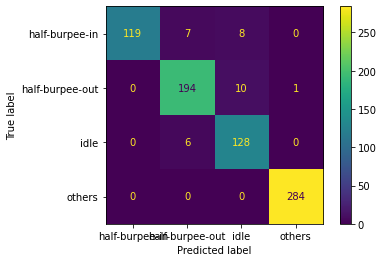

In [163]:
disp.plot()
plt.savefig(os.path.join(save_cm, 'kps_seq_cm.png'), dpi=300)
plt.show()

### ROC AUC

In [164]:
from sklearn.metrics import roc_auc_score

In [165]:
roc_auc_score(raw_test_y, raw_preds_y)

0.9967094724220897

# Detect in realtime

In [49]:
loaded_model = tf.keras.models.load_model(f'/data1-6tb/jom/EzFit_models/saved_models/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq.h5')

In [50]:
loaded_model.inputs

[<KerasTensor: shape=(None, 8, 99) dtype=float32 (created by layer 'lstm_2_input')>]

In [51]:
loaded_model.outputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_11')>]

In [52]:
# load le
with open(f'/data1-6tb/jom/EzFit_models/saved_pickles/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq_le.pickle', 'rb') as file:
    loaded_le = pickle.load(file)

In [53]:
from collections import deque, Counter

In [54]:
NUM_TEST_VIDS = 3
for i in range(1,1+NUM_TEST_VIDS):
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    rep_count = 0
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'/data1-6tb/jom/EzFit_models/objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    video_size = (640, 360) # original is (1920, 1080)
    video_writer = cv2.VideoWriter(f'/data1-6tb/jom/EzFit_models/output_videos/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_{i}_kps_seq{SUFFIX_VID_NAME}.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)

                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq)
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUFFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    class_name = "None"
                    prob = 0

                # count the rep logic
                current_stage = class_name

                if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
                    rep_count += 1

                previous_stage = current_stage

                print('rep:',rep_count, end='\r')
                
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

                # display rep count
                cv2.putText(image, 'Rep', (640-52, 0+15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(rep_count), (640-52, 0+50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

            except Exception as e:
                print('[INFO] error:', e)

            video_writer.write(image)
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        video_writer.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'alf-burpee-out 1.09998593
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: '

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'alf-burpee-out 0.99680596
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'alf-burpee-out 0

# Save class for visualization
only best performing model

In [55]:
NUM_TEST_VIDS = 3
for i in range(1, 1+NUM_TEST_VIDS):
    predicted_class = []
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    cap = cv2.VideoCapture(f'/data1-6tb/jom/EzFit_models/objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)
                
                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq)
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUFFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                        predicted_class.append(voted_pred)
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        predicted_class.append(y_idx)
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    predicted_class.append(0)
                    class_name = "None"
                    prob = 0
               
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

            except Exception as e:
                predicted_class.append(0)
                print('[INFO] error:', e)
            
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        
        assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
        
        temp_save_path = f'/data1-6tb/jom/EzFit_models/saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/len_{SEQ_LEN}/round_{ROUND}'
        if not os.path.exists(temp_save_path):
            os.makedirs(temp_save_path, exist_ok=True)
        with open(os.path.join(temp_save_path, f'test_vid_{i}_kps_seq{SUFFIX_VID_NAME}.pickle'), 'wb') as f:
            pickle.dump(predicted_class, f)
        cap.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'0.911397112784391690472858276
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'alf-burpee-out 1.09998593
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: '

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'alf-burpee-out 0.99680596
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'alf-burpee-out 0